# Generative Model (Coffees dataset)

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


In [21]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Load raw data and plot

In [22]:
# init data object
data_obj = Data('../../data/coffees/FTIR_instant_coffees.csv', 'label', -2)
data = data_obj.data
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
5,13.165349,13.587405,13.998584,13.476876,12.577613,11.989945,11.243600,10.692459,10.469784,10.374012,...,2.044999,2.023647,2.008715,1.990087,1.965167,1.953658,1.942450,1.930312,1,Arabica
33,14.108081,14.476337,14.516783,14.074631,13.217934,12.466894,11.724800,11.070709,10.706896,10.565004,...,1.896521,1.876392,1.852087,1.830727,1.813216,1.798814,1.783991,1.776107,2,Robusta
13,13.438294,13.687354,14.090918,13.742180,12.870400,12.025635,11.451002,11.097792,10.680395,10.490485,...,2.128728,2.106235,2.090319,2.074972,2.056196,2.039637,2.026209,2.019408,1,Arabica
19,11.708212,12.189027,12.115101,11.461263,10.624787,9.845979,9.528569,9.187627,8.901355,8.872402,...,1.934408,1.914148,1.901100,1.887963,1.871052,1.855958,1.838835,1.827901,1,Arabica


Arabica: blue
Robusta: red


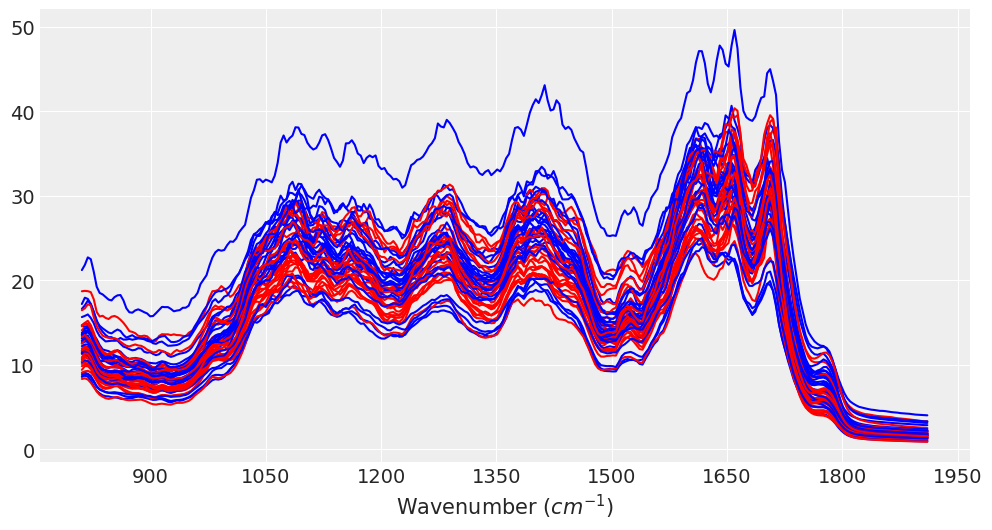

In [23]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 50)

In [24]:
# number of samples from each class
data[label_col].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

In [25]:
# store the data values for all different classes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

x_n = data.columns[:non_data_cols]
x_s = [df[i][x_n].values for i in range(len(df))]

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a,b} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [26]:
with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(len(class_labels),len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_s[0])
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_s[1])

    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:39<00:00, 50.41draws/s] 


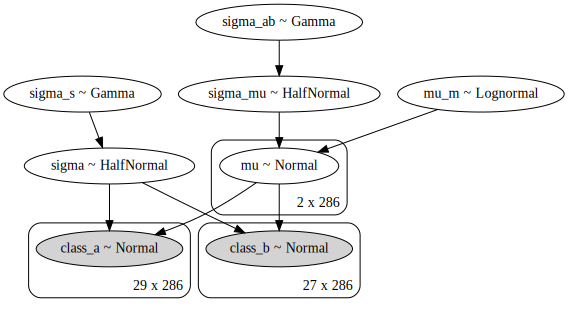

In [27]:
pm.model_to_graphviz(model_gm)

In [28]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",13.065,0.595,11.950,14.155,0.006,0.004,10989.0,10936.0,10929.0,2987.0,1.0
"mu[0,1]",13.344,0.606,12.181,14.434,0.007,0.005,8580.0,8483.0,8623.0,2840.0,1.0
"mu[0,2]",13.399,0.619,12.259,14.542,0.007,0.005,8026.0,7975.0,7969.0,2527.0,1.0
"mu[0,3]",12.948,0.600,11.766,14.008,0.006,0.004,9495.0,9495.0,9519.0,2762.0,1.0
"mu[0,4]",12.200,0.620,11.074,13.426,0.007,0.005,8698.0,8698.0,8535.0,2829.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,17.223,0.338,16.592,17.852,0.003,0.002,10027.0,10027.0,9994.0,2828.0,1.0
sigma_ab,4.363,1.302,2.317,6.777,0.017,0.015,5680.0,3938.0,8431.0,2779.0,1.0
sigma_mu,8.149,0.235,7.713,8.576,0.002,0.002,9833.0,9743.0,9906.0,2833.0,1.0
sigma_s,2.523,0.999,0.985,4.352,0.013,0.011,5807.0,3786.0,9764.0,2754.0,1.0


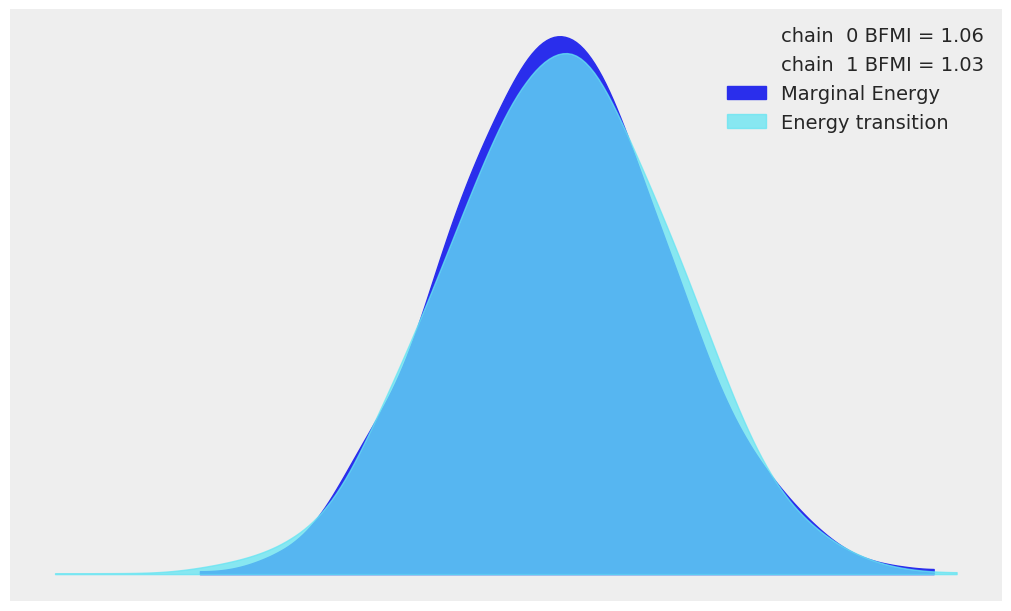

In [29]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [30]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:01<00:00, 145.41it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


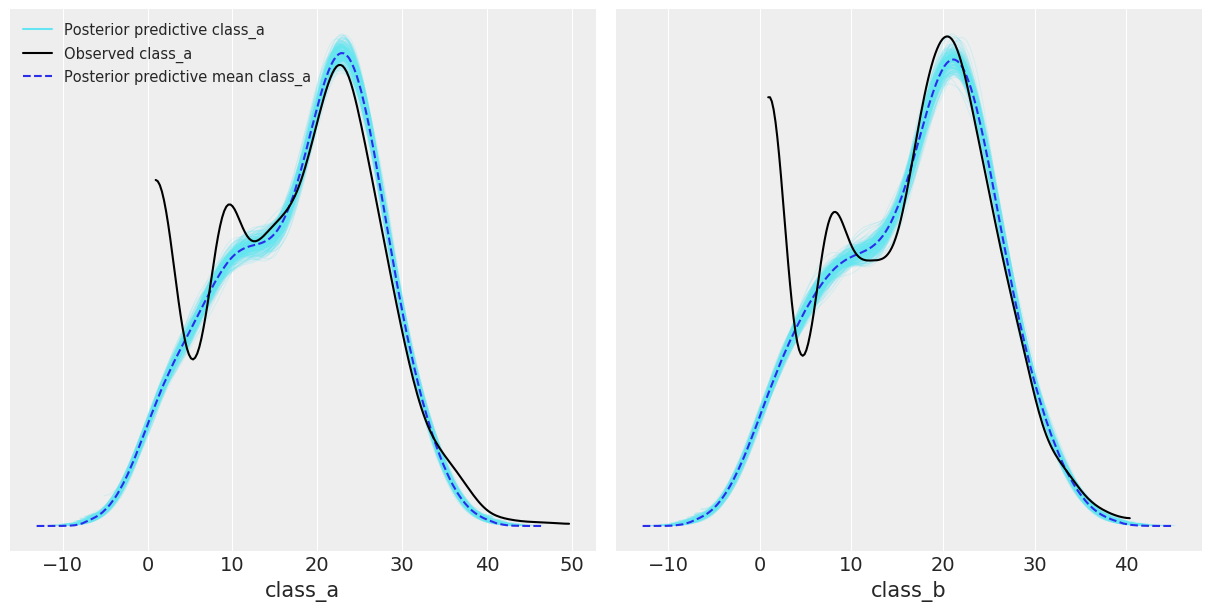

In [31]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [32]:
print(az.r2_score(x_s[0], ppc['class_a']))

r2        0.860709
r2_std    0.010736
dtype: float64


In [33]:
print(az.r2_score(x_s[1], ppc['class_b']))

r2        0.848577
r2_std    0.011458
dtype: float64


In [34]:
print(az.bfmi(trace_gm))

[1.06045045 1.02777974]


# Posterior samples vs. mean data

In [35]:
# class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']

ppc_class_lst = [cl_a, cl_b]

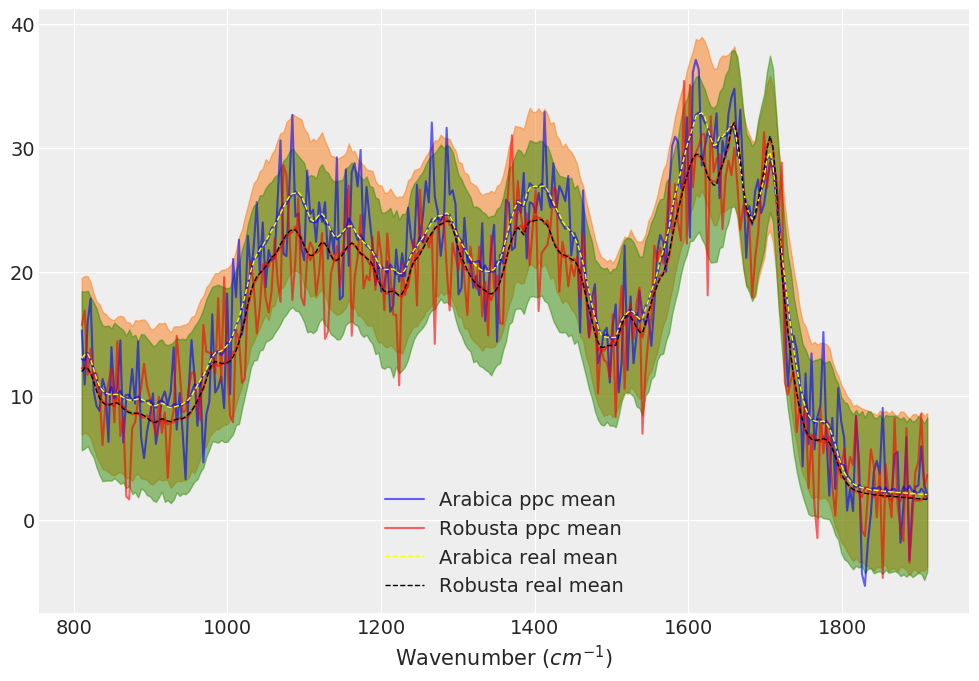

In [36]:
utl.plot_mean_vs_ppc(data_obj, ppc_class_lst)

# Real spectrum vs. posterior samples

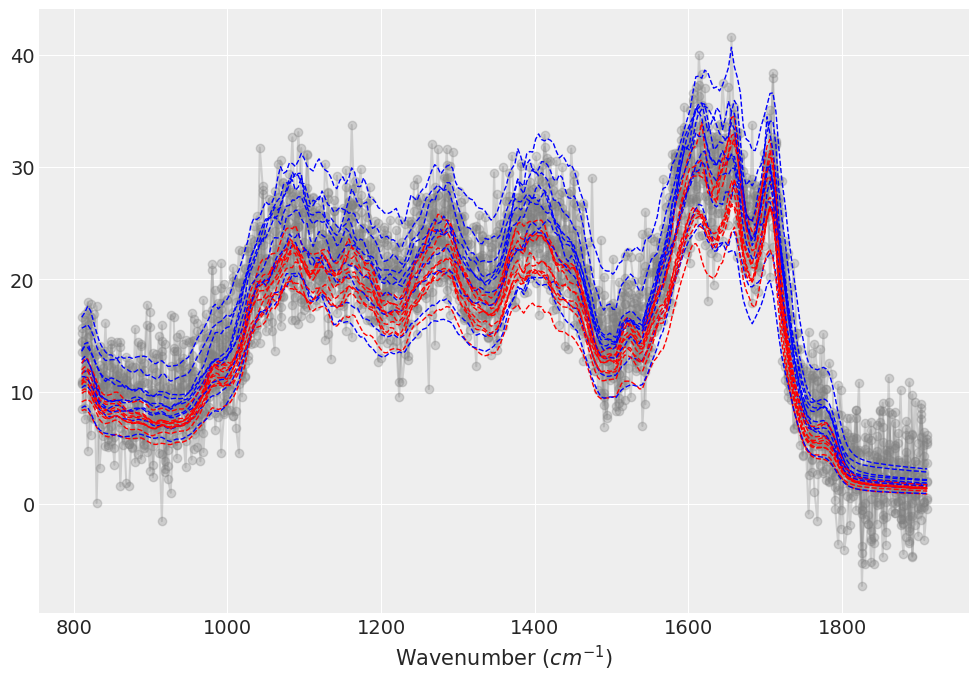

In [37]:
utl.plot_real_vs_ppc(data_obj, ppc_class_lst, 10)

# Save posterior samples to .csv file

In [38]:
utl.save_traces(data_obj, './ppc_samples_coffees.csv' , 100, ppc_class_lst)